# JAVELIN Hessian Scan Comparison

In this example we use two fitting methods: `javelike`, which mimics the behaviour of the lag fitting program [`JAVELIN`](https://github.com/nye17/javelin/commits?author=nye17), and litmus's signature INLA based `hessian_scan`. We'll show how, in even simple well characterized signals, seasonal gaps can cause MCMC-like samplers such as `JAVELIN` uses to fall afoul of the aliasing problem and severely distort out answers.

To begin, we'll import all the relevant modules:

In [1]:
from litmus import *
from litmus._utils import dict_extend
import jax
jax.config.update("jax_enable_x64", True)
plt.rcParams['mathtext.fontset'] = 'stix'

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Now we'll use the `litmus.mocks` module to generate some mock data:

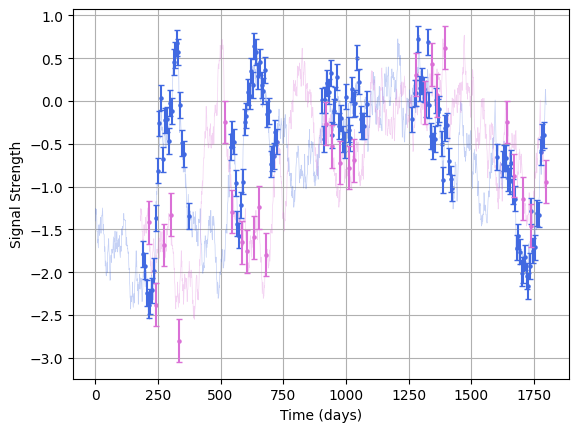

In [2]:
mock = mocks.mock(lag=180, cadende=[10, 30], E=[0.15, 0.25], tau=200)
mock = mock(10)
lc_1, lc_2 = mock.lc_1, mock.lc_2
mock.plot(show=True)
plt.show()

Now we create a stats model (specifically `models.GP_simple`, which models the response as an un-smoothed damped random walk), and set our prior ranges. In this case we'll numerical costs low by assuming we already know the signal mean's and relative amplitudes.

In [3]:
model = models.GP_simple()
model.set_priors({
    'lag': [0, 800],
    'mean': [0.0, 0.0],
    'rel_mean': [0.0, 0.0],
    'rel_amp': [1.00, 1.00],
})

To get an idea of _why_ aliasing happens, let's use `model` to evaluate the log-density in a slice over the lag prior with the other parameters fixed. Notice the multimodal behaviour within the (highlighted) aliasing seasons?

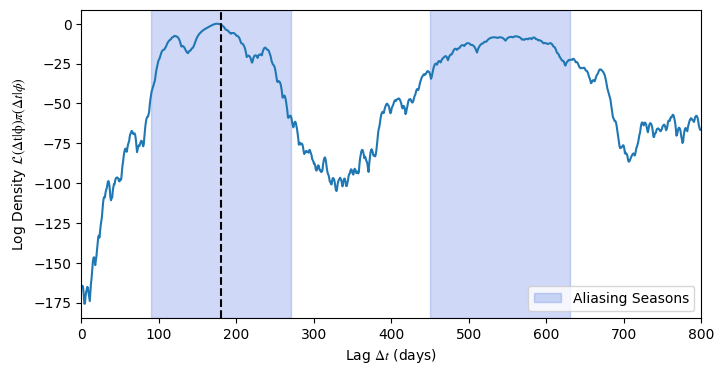

In [4]:
# Turn lightcurves into model-friendly data
data = model.lc_to_data(lc_1, lc_2)

# Set up a span of lags and calculate the model log-density conditioned on the data
lagplot = np.linspace(*model.prior_ranges['lag'], 1024)
LLs = model.log_density(dict_extend(mock.params(), {'lag': lagplot}), data)

# Plot likelihood and true lag
plt.figure(figsize=(8,4))
plt.plot(lagplot, (LLs - LLs.max()))
plt.axvline(mock.lag, ls='--', c='k')

# Highlight seasons
if mock.season != 0:
    tmax = model.prior_ranges['lag'][1]
    nyears = int(tmax // (mock.season * 2) + 1)
    for i in range(nyears):
        plt.axvspan((i + 1 / 2 - 1 / 4) * mock.season * 2, (i + 1 - 1 / 4) * mock.season * 2,
                    ymin=0, ymax=1, alpha=0.25, color='royalblue',
                    zorder=-10,
                    label="Aliasing Seasons" if i == 0 else None)

plt.xlim(0, model.prior_ranges['lag'][1])
plt.xlabel("Lag $\Delta t$ (days)")
plt.ylabel("Log Density $\mathcal{L(\Delta t \\vert \phi)}\pi(\Delta t \\vert \phi)$")
plt.legend()
plt.show()

That's all the mocks and statistics set up, now we set up two fitting method. Firstly, `meth_1` will be a `JAVELIKE`, i.e. an implementation of the AEIS, while `meth_2` will be `LITMUS`'s very own Hessian Scan. I've set the `debug` flag to `False` for each method for the sake of brevity, which otherwise would give granular detail about their inner workings, while I've kept the `verbose` flag, which outputs key information about the run progress, set to true. 

In [5]:
meth_1 = fitting_methods.JAVELIKE(model,
                                  verbose=False,
                                  debug=False,
                                  num_warmup=5_000,
                                  num_samples=100_000 // 512,
                                  num_chains=512
                                  )

meth_2 = fitting_methods.hessian_scan(model,
                                      verbose=False,
                                      debug=False,
                                      Nlags=64,
                                      precondition="half-eig",
                                      reverse=False
                                      )

Now we can run each method. We've already set the fitting procedures up, all that's required now is to run them! In this example I run `prefit()` and `fit()` seperately, though this is not strictly necessary.

I then load the fitting methods into a `LITMUS` object, which is a wrapper for generating nice fancy plots and data outputs. In this case, I save the chains with `save_chain` and generate the methods' respective lag posterior distributions with `lag_plot`:

Plots!
javelin


Tried to get 99840 sub-samples from chain of 50000 total samples. Tried to get 99840 sub-samples from chain of 50000 total samples. Warning! LITMUS object built on pre-run fitting_procedure. May have unexpected behaviour. 

hessian


Warning! LITMUS object built on pre-run fitting_procedure. May have unexpected behaviour. 

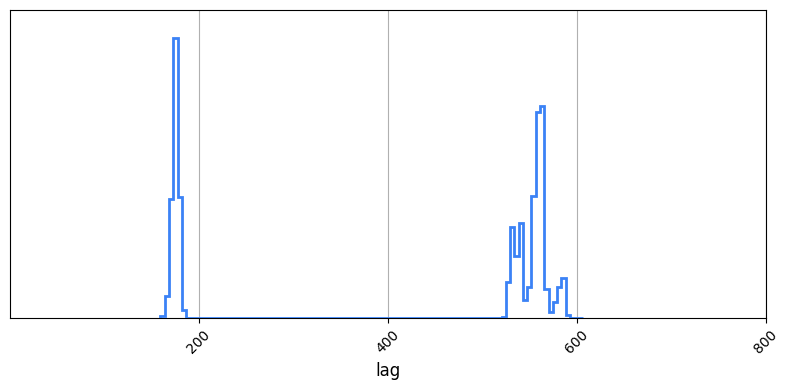

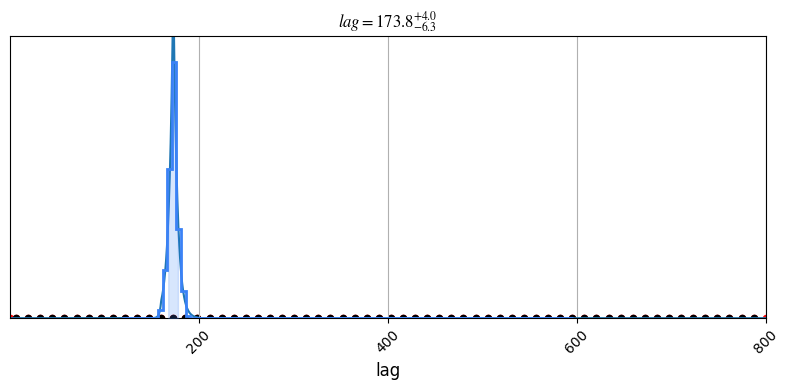

In [6]:
for meth, name in zip([meth_1, meth_2], ["javelin", 'hessian']):
    meth.prefit(lc_1, lc_2)
    meth.fit(lc_1, lc_2)

    lt = LITMUS(meth)
    lt.lag_plot()

There's one immediately obvious difference between the two contours: the `JAVELIN`-like `meth_1` has summoned a bimodal distribution out of nowhere, while the hessian scan of `meth_2` has not.